# Data Labelling

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('youtube_clean.csv')

In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
text = "I love Python programming! 😊"

def sentiment_determiner(text):

    sentiment = {'neg':0, 'pos':2, 'neu':1}
    sia = SentimentIntensityAnalyzer()

    sentiment_scores = sia.polarity_scores(text)
    sentiment_scores = [[i, j] for i, j in zip(sentiment_scores.values(),
                                               sentiment_scores.keys())][:-1]
    sentiment_scores = sorted(sentiment_scores, reverse=True)

    return sentiment[sentiment_scores[0][1]]

In [5]:
df['sentiment'] = df['text'].apply(sentiment_determiner)

In [6]:
df['sentiment'].value_counts()

1    9480
2     481
0     383
Name: sentiment, dtype: int64

# Data Cleaning

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from nltk.stem import PorterStemmer

# Download the stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
def full_text_cleaning(text):

    pattern = r'[A-Za-z]+'
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    text = re.findall(pattern, text)
    text = " ".join(text).lower()
    text = word_tokenize(text)
    text = [i for i in text if i.lower() not in stop_words]

    text = ' '.join([stemmer.stem(i) for i in text])

    return text

In [12]:
df['text'] = df['text'].apply(full_text_cleaning)

In [13]:
df.head()

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,author,published_at,updated_at,like_count,text,sentiment
0,0,0,0.0,0.0,0.0,@ৰংপাম,2024-07-23T08:22:17Z,2024-07-23T08:22:28Z,0,anyon,1
1,1,1,1.0,1.0,1.0,@abirroni3414,2024-07-23T08:17:02Z,2024-07-23T08:17:02Z,0,anyon juli,1
2,2,2,2.0,2.0,2.0,@EDMMixBeats,2024-07-23T07:20:28Z,2024-07-23T07:20:28Z,0,listen song mayb twice twice mean mayb coupl h...,1
3,4,4,4.0,4.0,4.0,@stanleygovender4535,2024-07-23T04:49:25Z,2024-07-23T04:49:25Z,1,much sex,1
4,5,5,5.0,5.0,5.0,@charlenegray9526,2024-07-23T02:59:28Z,2024-07-23T02:59:28Z,0,justin knew go crazi,1


# Feature extraction with bert

In [14]:
from transformers import BertModel, BertTokenizer
import torch

In [135]:
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [136]:
def extract_features(texts):

    embeddings = []
    for text in texts:

        inputs = tokenizer.encode(text,
                                  add_special_tokens=True,
                                  return_tensors='pt',
                                  return_truncation=True,
                                  max_length=512)

        with torch.no_grad():
            model_output = bert_model(inputs)
            last_hidden_states = model_output.last_hidden_state

        embeddings.append(last_hidden_states[:, 0 ,:]\
                          .squeeze()\
                          .numpy())

    return np.array(embeddings)

In [137]:
x = extract_features(df['text'])
y = df['sentiment']

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword

# Strategy 1

- ### Using train-test data spliting ratio of 4:1 and randomize the data 42 times
- ### Using GRU deep learning

In [18]:
from sklearn.model_selection import train_test_split

In [144]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [202]:
from tensorflow.keras.layers import GRU, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

In [145]:
model = Sequential()

model.add(GRU(128, input_shape=(x.shape[1], 1),
              return_sequences=True))
model.add(GRU(128))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [146]:
class myCallback(Callback):

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92:
            self.model.stop_training = True

In [147]:
history = model.fit(x_train.reshape(-1, x.shape[1], 1),
                    y_train,
                    validation_data=(x_test.reshape(-1, x.shape[1], 1),
                                     y_test),
                    epochs=50,
                    callbacks=[myCallback()])

Epoch 1/50
259/259 [==============================] - 336s 1s/step - loss: 0.3392 - accuracy: 0.9120 - val_loss: 0.2723 - val_accuracy: 0.9217
Epoch 2/50
259/259 [==============================] - 310s 1s/step - loss: 0.2543 - accuracy: 0.9230 - val_loss: 0.2302 - val_accuracy: 0.9280


# Strategy 2

- ### Using train-test data spliting ratio of 3:1 and randomize the data 42 times
- ### Using Decision Tree Classifier

In [24]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.25,
                                                    random_state=42)

In [34]:
model2 = DecisionTreeClassifier()
model2.fit(x_train,
           y_train)

DecisionTreeClassifier()

In [35]:
model2.score(x_test,
             y_test)

1.0

# Strategy 3

- ### Using train-test data spliting ratio of 85:15 and randomize the data 42 times
- ### Using Convolutional 1D and MaxPooling1D + GRU deep learning

In [148]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.15,
                                                    random_state=42)

In [207]:
model3 = Sequential()

model3.add(Conv1D(filters=64, kernel_size=3,
                  padding='same',
                  activation='relu',
                  input_shape=(x.shape[1], 1)))
model3.add(MaxPooling1D(pool_size=2))
model3.add(GRU(64))
model3.add(Dropout(0.2))
model3.add(Dense(256, activation='relu'))
model3.add(Dense(3, activation='softmax'))

model3.compile(optimizer=Adam(learning_rate=0.001),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [208]:
class myCallback(Callback):

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92:
            self.model.stop_training = True

In [209]:
history3 = model3.fit(x_train.reshape(-1, x.shape[1], 1),
                      y_train,
                      validation_data=(x_test.reshape(-1, x.shape[1], 1),
                                      y_test),
                      epochs=50,
                      callbacks=[myCallback()])

Epoch 1/50
259/259 [==============================] - 71s 256ms/step - loss: 0.3603 - accuracy: 0.9118 - val_loss: 0.2726 - val_accuracy: 0.9217
Epoch 2/50
259/259 [==============================] - 63s 244ms/step - loss: 0.2469 - accuracy: 0.9228 - val_loss: 0.2117 - val_accuracy: 0.9362


# Evaluation for each schema / strategy

In [210]:
import matplotlib.pyplot as plt

In [211]:
def evaluate_and_plot(schema):

    if schema == 'strategy 1':

        eval_history = history
        eval_model = model

        print(eval_model.evaluate(x_test.reshape(-1, x.shape[1], 1), y_test))
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(eval_history.history['accuracy'])
        plt.plot(eval_history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.subplot(1, 2, 2)
        plt.plot(eval_history.history['loss'])
        plt.plot(eval_history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.show()

    if schema == 'strategy 3':

        eval_history = history3
        eval_model = model3

        print(eval_model.evaluate(x_test.reshape(-1, x.shape[1], 1), y_test))
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(eval_history.history['accuracy'])
        plt.plot(eval_history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.subplot(1, 2, 2)
        plt.plot(eval_history.history['loss'])
        plt.plot(eval_history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.show()

    if schema == 'strategy 2':

      eval_model = model2
      print(eval_model.score(x_test,
                             y_test))


65/65 [==============================] - 26s 392ms/step - loss: 0.2302 - accuracy: 0.9280
[0.23020310699939728, 0.9279845356941223]


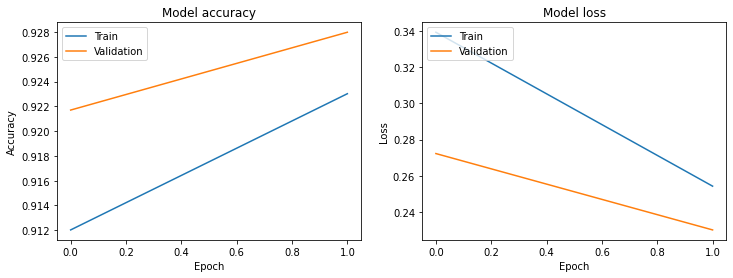

1.0
65/65 [==============================] - 5s 76ms/step - loss: 0.2117 - accuracy: 0.9362
[0.21173971891403198, 0.9362010359764099]


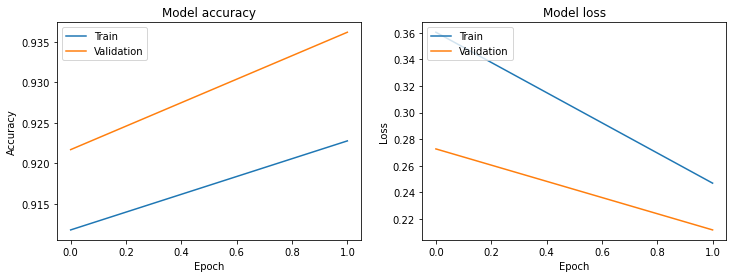

In [212]:
for schema in ['strategy 1', 'strategy 2', 'strategy 3']:
    evaluate_and_plot(schema)

# Saving all the models

In [90]:
from pickle import dump, load

In [213]:
model.save('model1.h5')
dump(model2, open('model2.pkl', 'wb'))
model3.save('model3.h5')

# Inference

In [138]:
def inference(schema):

    new_data = pd.read_csv('youtube_clean.csv')
    for i in range(10):
        new_data = new_data.sample(frac=1)
    new_data = new_data['text'].head(50)\
                               .apply(lambda x: str(x))
    new_content = new_data.copy()

    new_data = new_data.apply(full_text_cleaning)
    new_data = extract_features(new_data)

    if schema == 'strategy 1':

        model = load_model('model1.h5')
        predictions = model.predict(new_data)
        predicted_classes = np.argmax(predictions, axis=1)

    if schema == 'strategy 2':

        model2 = load(open('model2.pkl', 'rb'))
        predictions = model2.predict(new_data)
        predicted_classes = predictions

    if schema == 'strategy 3':

        model = load_model('model1.h5')
        predictions = model3.predict(new_data)
        predicted_classes = np.argmax(predictions, axis=1)

    predicted_df = pd.DataFrame({'text':new_content,
                                 'label':predicted_classes})\
                                 .reset_index(drop=True)\
                                 .replace({0:'Negatif',
                                           1:'Netral',
                                           2:'Positif'})

    return predicted_df

In [214]:
schema = 'strategy 2'
inference(schema)

Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword arguments {'return_truncation': True} not recognized.
Keyword 

,text,label
0,Tf was carti yappin bout his aura is carying tho,Netral
1,Who watching in,Netral
2,Bro caused a earthquake,Netral
3,Too much good watching the after few years,Netral
4,Anyone here in Jule lol,Netral
5,Anyone here in June Alguien aqui en Junio br I...,Netral
6,Anyone here in July,Netral
7,I watch this every fucking day,Netral
8,Perfect song for a situationship,Positif
9,This what it feel like when I had to much to d...,Netral


In [140]:
dump(bert_model, open('bert_model.pkl', 'wb'))
dump(tokenizer, open('bert_tokenizer.pkl', 'wb'))